<a href="https://colab.research.google.com/github/saigontrade88/AML-XAI-Project/blob/master/QuickStart_FasterAA_Feb232024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Quick Start: Creating Sample-wise Unlearnable Examples</h2>

<h3>Prepare Data</h3>

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Prepare Dataset
train_transform = [
    transforms.ToTensor()
]
test_transform = [
    transforms.ToTensor()
]
train_transform = transforms.Compose(train_transform)
test_transform = transforms.Compose(test_transform)

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
import os
import copy
import matplotlib.pyplot as plt
import json

# Visualize Images

In [4]:
import random
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

def get_pairs_of_imgs(idx, clean_train_dataset, unlearnable_dataset):
    clean_img = clean_train_dataset.data[idx]
    unlearnable_img = unlearnable_dataset.data[idx]
    clean_img = torchvision.transforms.functional.to_tensor(clean_img)
    unlearnable_img = torchvision.transforms.functional.to_tensor(unlearnable_img)

    # x = noise[idx]
    # x_min = torch.min(x)
    # x_max = torch.max(x)
    # noise_norm = (x - x_min) / (x_max - x_min)
    # noise_norm = torch.clamp(noise_norm, 0, 1)
    return [clean_img, unlearnable_img]

In [ ]:
def imshow(img):
  # img = (img * 0.5) + 0.5     # denormalize, [-1, 1] to [0, 1]
  if torch.is_tensor(img):
    npimg = img.numpy()
  else:
    npimg = img.astype(np.unit8)

  # if min_pixel == 0 and self.max_pixel == 1:
  #   img = np.clip(img * 255 + 0.5, 0, 255).astype(np.uint8)

  #       if self.min_pixel == -1 and self.max_pixel == 1:
  #           img = (img + 1) / 2 #[-1, 1] -> [0, 1]
  #           img = np.clip(img * 255 + 0.5, 0, 255).astype(np.uint8)

  if npimg.shape[0] == 3:
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
  else:
    plt.imshow(npimg)
  plt.show()

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Load Datasets

## Torch.Compose

In [ ]:
import numpy as np

# Add standard augmentation
train_transform = [
    transforms.ToTensor()
]
train_transform = transforms.Compose(train_transform)


# Explore your clean data

### x_train_orig_raw

In [ ]:
x_train = np.load(f'/content/x_train_orig.npy', allow_pickle=True)

In [ ]:
x_train.shape

(448, 32, 32, 3)

In [ ]:
len(x_train)

448

In [ ]:
x_train[0].shape

(32, 32, 3)

In [ ]:
type(x_train[0])

numpy.ndarray

In [ ]:
x_train[30].shape

(32, 32, 3)

In [ ]:
x_train[0].min()

0.16470587

In [ ]:
x_train[0].max()

1.0

In [ ]:
y_train = np.load(f'/content/y_train_orig.npy', allow_pickle=True)

In [ ]:
len(y_train)

448

In [ ]:
y_train[0], type(y_train[0])

(7, numpy.int64)

In [ ]:
y_train[6]

6

dog


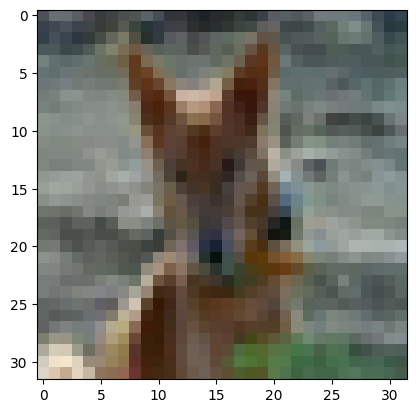

In [ ]:
print(f'{classes[y_train[2]]}')
imshow(x_train[2])

### x_aug_raw

In [ ]:
x_aug = np.load(f'/content/x_train_aug.npy', allow_pickle=True)

In [ ]:
#num_elements
len(x_aug)

448

In [ ]:
#first batch
x_aug[0].shape

(32, 32, 3)

In [ ]:
#last batch
x_aug[0].shape

(32, 32, 3)

In [ ]:
x_aug[0].min()

0.12870371

In [ ]:
x_aug[0].max()

0.96953213

In [ ]:
y_train_aug = np.load(f'/content/y_train_aug.npy')

In [ ]:
y_train_pred = np.load(f'/content/y_train_pred.npy')

dog
dog


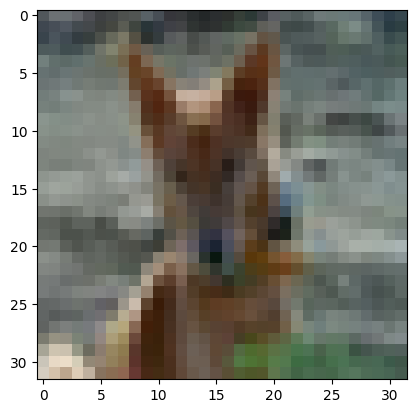

In [ ]:
print(f'{classes[y_train_aug[2]]}') , print(f'{classes[y_train_pred[2]]}')
imshow(x_aug[2])

In [ ]:
classes[y_train[2]], classes[y_train_aug[2]], classes[y_train_pred[2]]

('dog', 'dog', 'dog')

# Data pipeline that uses torchvision

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
class Cifar10UnlearnableDataset(Dataset):
    """
    a subclass of torch.utils.data.Dataset
    Thus, it is required to implement two methods: __len__ and __getitem__.
    """
    def __init__(self, data_X, data_y, min_pixel, max_pixel, transform=None):
        '''
        data_X: numpy array, shape (40000, 32, 32, 3).
        data_Y: numpy array, shape (40000, 10)

        '''
        self.data = data_X
        self.targets = data_y # Return a Python list with a single element

        self.transforms = transform

        self.min_pixel = min_pixel
        self.max_pixel = max_pixel

    def __getitem__(self, index):
        """
        train_transform = torchvision.transforms([ToTensor(),])
        myDataset = Cifar10NTGADataset(data_X, data_y, train_transform)
        img, label = cifar10[99]
        """

        img, target = self.data[index], self.targets[index]

        if img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0)) #(height, width, channel)

        # Check the data type of the array
        # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
        if self.min_pixel == 0 and self.max_pixel == 1:
            img = np.clip(img * 255 + 0.5, 0, 255).astype(np.uint8)

        if self.min_pixel == -1 and self.max_pixel == 1:
            img = (img + 1) / 2 #[-1, 1] -> [0, 1]
            img = np.clip(img * 255 + 0.5, 0, 255).astype(np.uint8)

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transforms:
        # Use torchvision.transforms module to convert the PIL image to a PyTorch tensor
            img = self.transforms(img)

        # return a Pytorch tensor and its corresponding label and the pixel values range from 0.0 to 1.0.
        return img, target

In [ ]:
unlearnable_train_dataset = Cifar10UnlearnableDataset(x_train,
                                                y_train,
                                                0, 1,
                            transform=train_transform)

In [ ]:
temp, temp_label = unlearnable_train_dataset[2]

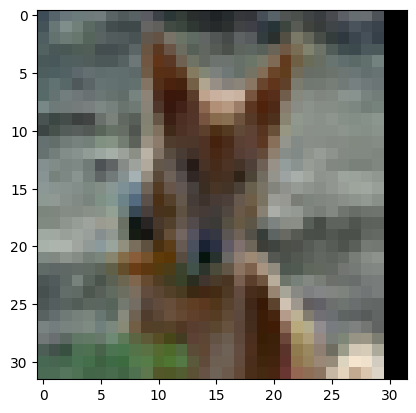

In [ ]:
imshow(temp)

In [ ]:
aug_train_dataset = Cifar10UnlearnableDataset(x_aug,
                                                y_train_aug,
                                                0, 1,
                            transform=train_transform)

In [ ]:
temp, temp_label = aug_train_dataset[2]

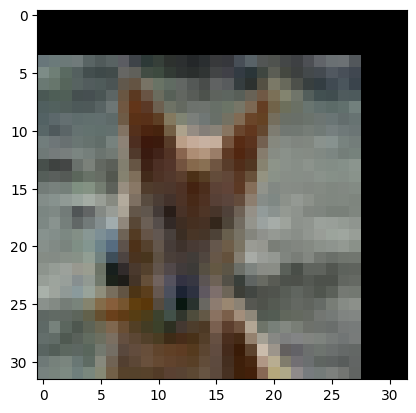

In [ ]:
imshow(temp)

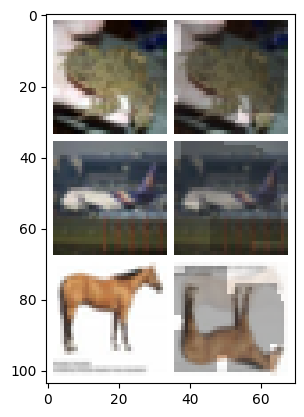

In [ ]:
selected_idx = [random.randint(0, 400) for _ in range(3)]
img_grid = []
for idx in selected_idx:
    img_grid += get_pairs_of_imgs(idx, unlearnable_train_dataset, aug_train_dataset)


imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=2, pad_value=255))

# Data pipeline that uses Albumentations

In [ ]:
class Cifar10UnlearnableDataset(torch.utils.data.Dataset):

    def __init__(self, root='/work_bgfs/l/longdang/alldatasets/min-min-noise/cifar10',
        x_train_file='emin_perturbed_x',
        y_train_file='y_train_cifar10', train_size=4000, transform=None):

        self.transform = transform
        # Implement additional initialization logic if needed
        dataX = np.load(f'{root}/{x_train_file}.npy')
        dataY = np.load(f'{root}/{y_train_file}.npy')

        # indices = torch.randperm(len(dataX))[:train_size]
        # x_train = [dataX[i] for i in indices]
        # y_train = [dataY[i] for i in indices]
        self.data = dataX
        self.targets = dataY # Return a Python list


    def __len__(self):
        # Replace `...` with the actual implementation
        return len(self.data)

    def __getitem__(self, index):
        # Implement logic to get an image and its label using the received index.
        #
        # `image` should be a NumPy array with the shape [height, width, num_channels].
        # If an image contains three color channels, it should use an RGB color scheme.
        #
        # `label` should be an integer in the range [0, model.num_classes - 1] where `model.num_classes`
        # is a value set in the `search.yaml` file.


        image = self.data[index]
        label = self.targets[index]

        if image.shape[0] == 3:
            image = np.transpose(image, (1, 2, 0))

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

## albumentations_transform

In [ ]:
albumentations_transform = A.Compose([
    ToTensorV2()
])

In [ ]:
unlearnable_train_dataset = Cifar10UnlearnableDataset('/content/',
                                                      'x_train_orig',
                                                      'y_train_orig',
                                                      train_size=1000,
                            transform=albumentations_transform)

In [ ]:
unlearnable_aug_dataset = Cifar10UnlearnableDataset('/content/',
                                                      'x_train_aug',
                                                      'y_train_aug',
                                                      train_size=1000,
                            transform=albumentations_transform)

In [ ]:
temp, temp_label = unlearnable_train_dataset[2]

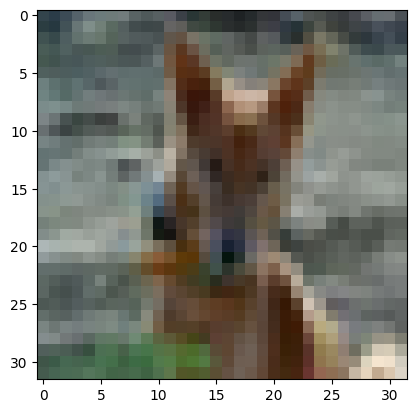

In [ ]:
imshow(temp)

In [ ]:
temp, temp_label = unlearnable_aug_dataset[2]

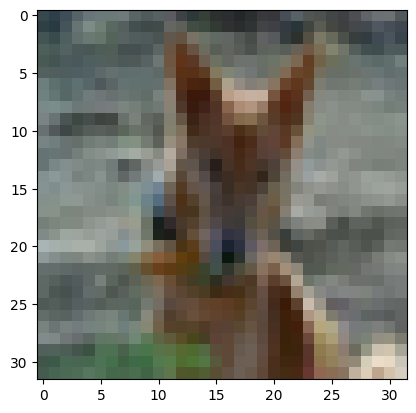

In [ ]:
imshow(temp)

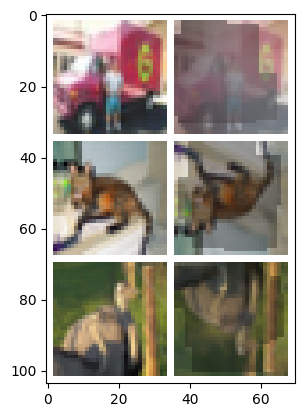

In [ ]:
selected_idx = [random.randint(0, 400) for _ in range(3)]
img_grid = []
for idx in selected_idx:
  img_grid += get_pairs_of_imgs(idx, unlearnable_train_dataset, unlearnable_aug_dataset)


imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=2, pad_value=255))

In [ ]:
unlearnable_train_loader = torch.utils.data.DataLoader(unlearnable_train_dataset, batch_size=128,
                                          shuffle=True, num_workers=2)

In [ ]:
unlearnable_aug_loader = torch.utils.data.DataLoader(unlearnable_aug_dataset, batch_size=128,
                                          shuffle=True, num_workers=2)

# Prepare model

In [ ]:
!pip install mlconfig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=d9f4f905961948ad16d645665d0eb811f350e070eb56942350a531bf6f0ecaad
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [ ]:
from models.ResNet import ResNet18


torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

model = ResNet18()
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)



In [ ]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

In [ ]:
clean_test_dataset = datasets.CIFAR10(root='../datasets', train=False, download=True, transform=test_transform)

clean_test_loader = DataLoader(dataset=clean_test_dataset, batch_size=512,
                                shuffle=False, pin_memory=True,
                                drop_last=False, num_workers=12)

100%|██████████| 170498071/170498071 [00:04<00:00, 38681420.02it/s]


Extracting ../datasets/cifar-10-python.tar.gz to ../datasets


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Train on unlearnable training set

In [ ]:
from tqdm import tqdm
from util import AverageMeter

for epoch in range(30):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm(unlearnable_train_loader, total=len(unlearnable_train_loader))
    for images, labels in pbar:
        images, labels = images.cuda(), labels.cuda()
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    scheduler.step()
    # Eval
    model.eval()
    correct, total = 0, 0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = model(images)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    tqdm.write('Clean Accuracy %.2f\n' % (acc*100))

Acc 14.84 Loss: 2.64: 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


Clean Accuracy 10.00



Acc 17.97 Loss: 3.12: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Clean Accuracy 11.73



Acc 20.12 Loss: 2.99: 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]


Clean Accuracy 9.51



Acc 20.90 Loss: 2.78: 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


Clean Accuracy 10.35



Acc 17.77 Loss: 2.40: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Clean Accuracy 9.40



Acc 25.39 Loss: 2.32: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]


Clean Accuracy 10.81



Acc 20.31 Loss: 2.24: 100%|██████████| 4/4 [00:00<00:00,  8.60it/s]


Clean Accuracy 15.45



Acc 26.95 Loss: 2.25: 100%|██████████| 4/4 [00:00<00:00,  7.42it/s]


Clean Accuracy 13.85



Acc 30.66 Loss: 2.05: 100%|██████████| 4/4 [00:00<00:00,  8.37it/s]


Clean Accuracy 12.90



Acc 33.59 Loss: 1.89: 100%|██████████| 4/4 [00:00<00:00,  8.54it/s]


Clean Accuracy 12.43



Acc 36.52 Loss: 1.79: 100%|██████████| 4/4 [00:00<00:00,  7.68it/s]


Clean Accuracy 14.54



Acc 35.74 Loss: 1.74: 100%|██████████| 4/4 [00:00<00:00,  8.39it/s]


Clean Accuracy 18.52



Acc 39.45 Loss: 1.65: 100%|██████████| 4/4 [00:00<00:00,  8.40it/s]


Clean Accuracy 26.15



Acc 41.99 Loss: 1.59: 100%|██████████| 4/4 [00:00<00:00,  7.43it/s]


Clean Accuracy 27.34



Acc 44.92 Loss: 1.43: 100%|██████████| 4/4 [00:00<00:00,  7.95it/s]


Clean Accuracy 27.26



Acc 46.88 Loss: 1.45: 100%|██████████| 4/4 [00:00<00:00,  8.43it/s]


Clean Accuracy 28.93



Acc 47.27 Loss: 1.38: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s]


Clean Accuracy 27.47



Acc 49.80 Loss: 1.35: 100%|██████████| 4/4 [00:00<00:00,  7.34it/s]


Clean Accuracy 30.27



Acc 54.49 Loss: 1.22: 100%|██████████| 4/4 [00:00<00:00,  8.09it/s]


Clean Accuracy 30.09



Acc 58.59 Loss: 1.14: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]


Clean Accuracy 30.49



Acc 57.62 Loss: 1.11: 100%|██████████| 4/4 [00:00<00:00,  8.11it/s]


Clean Accuracy 33.54



Acc 68.36 Loss: 0.97: 100%|██████████| 4/4 [00:00<00:00,  7.67it/s]


Clean Accuracy 33.25



Acc 65.04 Loss: 0.96: 100%|██████████| 4/4 [00:00<00:00,  8.05it/s]


Clean Accuracy 33.19



Acc 72.27 Loss: 0.85: 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]


Clean Accuracy 33.59



Acc 74.61 Loss: 0.78: 100%|██████████| 4/4 [00:00<00:00,  4.48it/s]


Clean Accuracy 33.91



Acc 75.59 Loss: 0.74: 100%|██████████| 4/4 [00:00<00:00,  8.06it/s]


Clean Accuracy 34.12



Acc 73.83 Loss: 0.75: 100%|██████████| 4/4 [00:00<00:00,  8.19it/s]


Clean Accuracy 34.38



Acc 78.32 Loss: 0.66: 100%|██████████| 4/4 [00:00<00:00,  8.06it/s]


Clean Accuracy 34.03



Acc 77.15 Loss: 0.71: 100%|██████████| 4/4 [00:00<00:00,  8.05it/s]


Clean Accuracy 33.91



Acc 79.49 Loss: 0.64: 100%|██████████| 4/4 [00:00<00:00,  7.80it/s]


Clean Accuracy 33.90



## Train on unlearnable augmented training set

In [ ]:
model = ResNet18()
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)

In [ ]:
from tqdm import tqdm
from util import AverageMeter

for epoch in range(30):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm(unlearnable_aug_loader, total=len(unlearnable_aug_loader))
    for images, labels in pbar:
        images, labels = images.cuda(), labels.cuda()
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    scheduler.step()
    # Eval
    model.eval()
    correct, total = 0, 0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = model(images)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    tqdm.write('Clean Accuracy %.2f\n' % (acc*100))

Acc 13.48 Loss: 2.68: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s]


Clean Accuracy 10.00



Acc 16.02 Loss: 3.13: 100%|██████████| 4/4 [00:00<00:00,  8.17it/s]


Clean Accuracy 10.09



Acc 16.99 Loss: 2.60: 100%|██████████| 4/4 [00:00<00:00,  8.15it/s]


Clean Accuracy 7.91



Acc 19.73 Loss: 2.41: 100%|██████████| 4/4 [00:00<00:00,  7.91it/s]


Clean Accuracy 11.96



Acc 21.48 Loss: 2.54: 100%|██████████| 4/4 [00:00<00:00,  7.93it/s]


Clean Accuracy 11.73



Acc 25.20 Loss: 2.13: 100%|██████████| 4/4 [00:00<00:00,  7.97it/s]


Clean Accuracy 16.01



Acc 29.49 Loss: 2.06: 100%|██████████| 4/4 [00:00<00:00,  7.92it/s]


Clean Accuracy 16.57



Acc 30.08 Loss: 1.94: 100%|██████████| 4/4 [00:00<00:00,  8.01it/s]


Clean Accuracy 22.02



Acc 29.88 Loss: 2.03: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s]


Clean Accuracy 22.89



Acc 34.18 Loss: 1.96: 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]


Clean Accuracy 16.39



Acc 32.42 Loss: 1.86: 100%|██████████| 4/4 [00:00<00:00,  7.92it/s]


Clean Accuracy 20.10



Acc 34.18 Loss: 1.81: 100%|██████████| 4/4 [00:00<00:00,  7.70it/s]


Clean Accuracy 15.27



Acc 34.38 Loss: 1.74: 100%|██████████| 4/4 [00:00<00:00,  7.73it/s]


Clean Accuracy 22.36



Acc 35.74 Loss: 1.63: 100%|██████████| 4/4 [00:00<00:00,  8.19it/s]


Clean Accuracy 23.68



Acc 43.36 Loss: 1.52: 100%|██████████| 4/4 [00:00<00:00,  8.06it/s]


Clean Accuracy 25.31



Acc 45.31 Loss: 1.51: 100%|██████████| 4/4 [00:00<00:00,  8.10it/s]


Clean Accuracy 23.13



Acc 48.44 Loss: 1.40: 100%|██████████| 4/4 [00:00<00:00,  8.03it/s]


Clean Accuracy 21.84



Acc 45.31 Loss: 1.54: 100%|██████████| 4/4 [00:00<00:00,  7.89it/s]


Clean Accuracy 14.67



Acc 43.16 Loss: 1.50: 100%|██████████| 4/4 [00:00<00:00,  8.15it/s]


Clean Accuracy 22.37



Acc 51.56 Loss: 1.32: 100%|██████████| 4/4 [00:00<00:00,  7.33it/s]


Clean Accuracy 18.99



Acc 54.88 Loss: 1.22: 100%|██████████| 4/4 [00:00<00:00,  8.12it/s]


Clean Accuracy 21.78



Acc 54.10 Loss: 1.23: 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]


Clean Accuracy 25.45



Acc 61.52 Loss: 1.06: 100%|██████████| 4/4 [00:00<00:00,  7.60it/s]


Clean Accuracy 15.87



Acc 63.28 Loss: 1.00: 100%|██████████| 4/4 [00:00<00:00,  8.11it/s]


Clean Accuracy 24.06



Acc 60.74 Loss: 1.07: 100%|██████████| 4/4 [00:00<00:00,  8.01it/s]


Clean Accuracy 19.24



Acc 65.43 Loss: 0.91: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s]


Clean Accuracy 17.24



Acc 67.58 Loss: 0.84: 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]


Clean Accuracy 19.65



Acc 72.66 Loss: 0.77: 100%|██████████| 4/4 [00:00<00:00,  7.80it/s]


Clean Accuracy 25.01



Acc 72.85 Loss: 0.79: 100%|██████████| 4/4 [00:00<00:00,  7.90it/s]


Clean Accuracy 24.67



Acc 72.46 Loss: 0.79: 100%|██████████| 4/4 [00:00<00:00,  8.05it/s]


Clean Accuracy 23.14



# Explore Emin (need to be updated for all the remaining)

## Emin with normalization

In [5]:
def imshow(img, min_pixel, max_pixel):
  if min_pixel == 0 and max_pixel == 1:
    img = np.clip(img * 255 + 0.5, 0, 255).astype(np.uint8)

  if min_pixel == -1 and max_pixel == 1:
    img = (img + 1) / 2 #[-1, 1] -> [0, 1]
    img = np.clip(img * 255 + 0.5, 0, 255).astype(np.uint8)

  if img.shape[0] == 3:
    plt.imshow(np.transpose(img, (1, 2, 0)))
  else:
    plt.imshow(img.astype(np.uint8))
  plt.show()

In [ ]:
albumentations_transform = A.Compose([
    A.RandomCrop(32, 32),
    A.HorizontalFlip(),
    A.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    ToTensorV2()
])

In [ ]:
unlearnable_train_dataset = Cifar10UnlearnableDataset('/content/',
                                                      'emin_perturbed_x',
                                                      'y_train_cifar10',
                                                      train_size=50000,
                            transform=albumentations_transform)

#### Unlearnable examples with ResNet18 model

In [ ]:
u_x_train = np.load(f'/content/ResNet18/x_train_orig.npy', allow_pickle=True)

In [ ]:
u_x_train.shape

(448, 32, 32, 3)

In [ ]:
u_x_train[0].min()

34.0

In [ ]:
u_x_train[0].max()

255.0

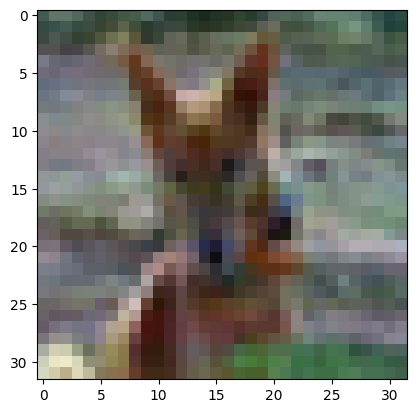

In [ ]:
imshow(u_x_train[2], 0, 255)

#### Unlearnable augmented examples with ResNet18 model

In [ ]:
u_x_train_aug = np.load(f'/content/ResNet18/x_train_aug.npy', allow_pickle=True)

In [ ]:
u_x_train_aug.shape

(448, 32, 32, 3)

In [ ]:
u_x_train_aug[0].min()

0.68072015

In [ ]:
u_x_train_aug[0].max()

0.99999994

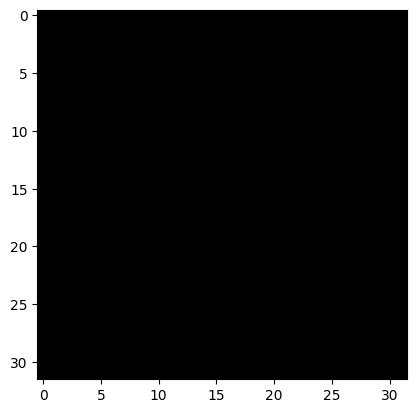

In [ ]:
imshow(u_x_train_aug[2], 0, 255) #need more iterations

#### Unlearnable examples with WideResNet

In [ ]:
u_x_train = np.load(f'/content/x_train_orig.npy', allow_pickle=True)

In [ ]:
u_x_train.shape

(1984, 32, 32, 3)

In [ ]:
u_x_train[2].min()

0.0

In [ ]:
u_x_train[2].max()

249.0

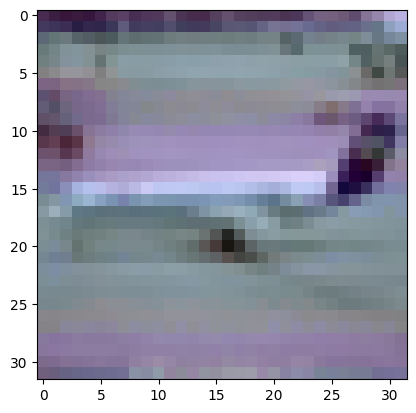

In [ ]:
imshow(u_x_train[2], 0, 255) #need more iterations

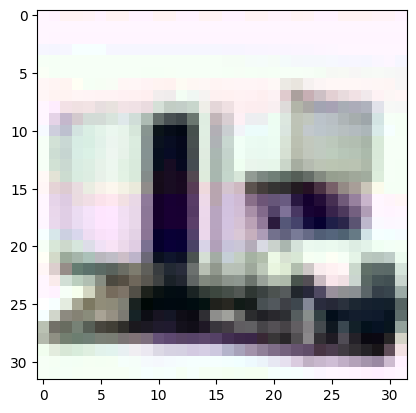

In [ ]:
u_x_train = np.load(f'/content/seq4/x_train_orig.npy', allow_pickle=True)
imshow(u_x_train[2], 0, 255) #need more iterations

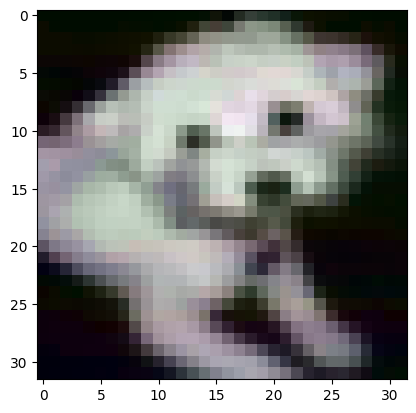

In [ ]:
u_x_train = np.load(f'/content/seq8/x_train_orig.npy', allow_pickle=True)
imshow(u_x_train[2], 0, 255) #need more iterations

### Unlearnable augmented examples with WideResNet

In [ ]:
import numpy as np
u_x_train_aug = np.load(f'/content/x_train_aug.npy', allow_pickle=True)

In [ ]:
u_x_train_aug.shape, u_x_train_aug[2].min(), u_x_train_aug[2].max()

((1984, 32, 32, 3), 0.006973058, 0.99992466)

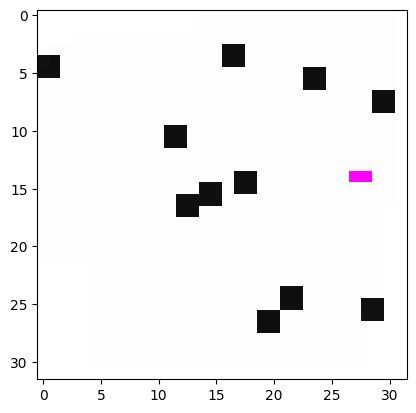

In [ ]:
imshow(u_x_train_aug[2], 0, 1)

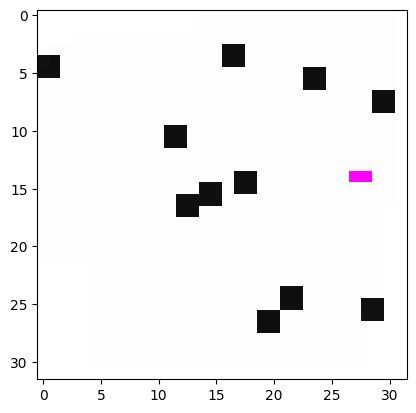

In [ ]:
imshow(u_x_train_aug[2], 0, 1)

In [ ]:
u_x_train_aug = np.load(f'/content/seq4/x_train_aug.npy', allow_pickle=True)

In [ ]:
u_x_train_aug.shape, u_x_train_aug[2].min(), u_x_train_aug[2].max()

((1984, 32, 32, 3), 0.54677546, 0.9852516)

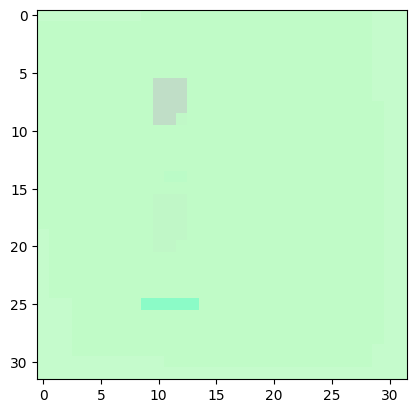

In [ ]:
imshow(u_x_train_aug[2], 0, 1)

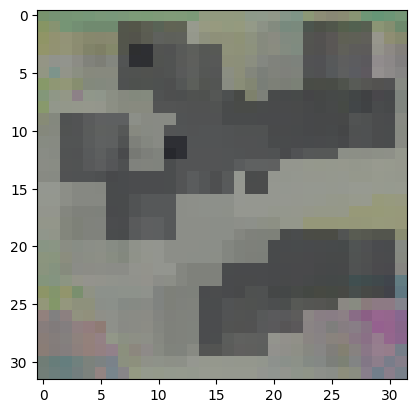

In [ ]:
u_x_train_aug = np.load(f'/content/seq8/x_train_aug.npy', allow_pickle=True)
imshow(u_x_train_aug[2], 0, 1)

In [ ]:
selected_idx = [random.randint(0, 50000) for _ in range(3)]
img_grid = []
for idx in selected_idx:
  img_grid += get_pairs_of_imgs(idx, clean_train_dataset, unlearnable_train_dataset)


imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=2, pad_value=255))

In [ ]:
unlearnable_train_dataset = Cifar10UnlearnableDataset('/content/',
                                                      'emin_perturbed_x',
                                                      'y_train_cifar10',
                                                      train_size=4000,
                            transform=albumentations_transform)

In [ ]:
selected_idx = [random.randint(0, 4000) for _ in range(3)]
img_grid = []
for idx in selected_idx:
  img_grid += get_pairs_of_imgs(idx, clean_train_dataset, unlearnable_train_dataset)


imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=2, pad_value=255))

## Deep Confuse

In [ ]:
albumentations_transform = A.Compose([
    A.RandomCrop(32, 32),
    A.HorizontalFlip(),
    A.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    ToTensorV2()
])

In [ ]:
unlearnable_train_dataset = Cifar10UnlearnableDataset('/content/',
                                                      'deepconfuse_perturbed_x',
                                                      'y_train_cifar10',
                                                      train_size=50000,
                            transform=albumentations_transform)


In [ ]:
selected_idx = [random.randint(0, 50000) for _ in range(3)]
img_grid = []
for idx in selected_idx:
  img_grid += get_pairs_of_imgs(idx, clean_train_dataset, unlearnable_train_dataset)


imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=2, pad_value=255))

In [ ]:
unlearnable_train_dataset = Cifar10UnlearnableDataset('/content/',
                                                      'deepconfuse_perturbed_x',
                                                      'y_train_cifar10',
                                                      train_size=4000,
                            transform=albumentations_transform)

In [ ]:
selected_idx = [random.randint(0, 4000) for _ in range(3)]
img_grid = []
for idx in selected_idx:
  img_grid += get_pairs_of_imgs(idx, clean_train_dataset, unlearnable_train_dataset)


imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=2, pad_value=255))

## Syn_perturbed

In [ ]:
albumentations_transform = A.Compose([
    A.RandomCrop(32, 32),
    A.HorizontalFlip(),
    A.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    ToTensorV2()
])

In [ ]:
unlearnable_train_dataset = Cifar10UnlearnableDataset('/content/',
                                                      'syn_perturbed_x',
                                                      'y_train_cifar10',
                                                      train_size=50000,
                            transform=albumentations_transform)


In [ ]:
selected_idx = [random.randint(0, 50000) for _ in range(3)]
img_grid = []
for idx in selected_idx:
  img_grid += get_pairs_of_imgs(idx, clean_train_dataset, unlearnable_train_dataset)


imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=2, pad_value=255))

In [ ]:
unlearnable_train_dataset = Cifar10UnlearnableDataset('/content/',
                                                      'syn_perturbed_x',
                                                      'y_train_cifar10',
                                                      train_size=4000,
                            transform=albumentations_transform)

In [ ]:
selected_idx = [random.randint(0, 4000) for _ in range(3)]
img_grid = []
for idx in selected_idx:
  img_grid += get_pairs_of_imgs(idx, clean_train_dataset, unlearnable_train_dataset)


imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=2, pad_value=255))

## Emax

In [ ]:
unlearnable_train_dataset = Cifar10UnlearnableDataset('/content/',
                                                      'emax_perturbed_x',
                                                      'y_train_cifar10',
                                                      train_size=40000,
                            transform=albumentations_transform)

In [ ]:
selected_idx = [random.randint(0, 40000) for _ in range(3)]
img_grid = []
for idx in selected_idx:
  img_grid += get_pairs_of_imgs(idx, clean_train_dataset, unlearnable_train_dataset)


imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=2, pad_value=255))

In [ ]:
unlearnable_train_dataset = Cifar10UnlearnableDataset('/content/',
                                                      'emax_perturbed_x',
                                                      'y_train_cifar10',
                                                      train_size=4000,
                            transform=albumentations_transform)

In [ ]:
selected_idx = [random.randint(0, 4000) for _ in range(3)]
img_grid = []
for idx in selected_idx:
  img_grid += get_pairs_of_imgs(idx, clean_train_dataset, unlearnable_train_dataset)


imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=2, pad_value=255))

## NTGA

In [ ]:
x_train_ntga = np.load('x_train_cifar10_unlearn.npy')

In [ ]:
len(x_train_ntga)

In [ ]:
unlearnable_train_dataset = Cifar10UnlearnableDataset('/content/',
                                                      'x_train_cifar10_unlearn',
                                                      'y_train_cifar10',
                                                      train_size=40000,
                            transform=albumentations_transform)

In [ ]:
selected_idx = [random.randint(0, 40000) for _ in range(3)]
img_grid = []
for idx in selected_idx:
  img_grid += get_pairs_of_imgs(idx, clean_train_dataset, unlearnable_train_dataset)


imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=2, pad_value=255))

In [ ]:
unlearnable_train_dataset = Cifar10UnlearnableDataset('/content/',
                                                      'x_train_cifar10_unlearn',
                                                      'y_train_cifar10',
                                                      train_size=4000,
                            transform=albumentations_transform)

In [ ]:
selected_idx = [random.randint(0, 4000) for _ in range(3)]
img_grid = []
for idx in selected_idx:
  img_grid += get_pairs_of_imgs(idx, clean_train_dataset, unlearnable_train_dataset)


imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=2, pad_value=255))

<h3>Train ResNet18 on Unlearnable Dataset</h3>

In [ ]:
from util import AverageMeter

model = ResNet18()
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

unlearnable_loader = DataLoader(dataset=unlearnable_train_dataset, batch_size=128,
                                shuffle=True, pin_memory=True,
                                drop_last=False, num_workers=12)


for epoch in range(30):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm(unlearnable_loader, total=len(unlearnable_loader))
    for images, labels in pbar:
        images, labels = images.cuda(), labels.cuda()
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    scheduler.step()
    # Eval
    model.eval()
    correct, total = 0, 0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = model(images)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    tqdm.write('Clean Accuracy %.2f\n' % (acc*100))
